In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
input_size = 3
hidden_sizes = [2, 3] 
output_size = 1
initial_activation_list = [jax.nn.relu, jax.nn.tanh, sin]

hetero_config = MLPConfig(input_size=input_size,
                        output_size=output_size,
                        hidden_sizes=hidden_sizes,
                        initial_activation_list=initial_activation_list,
                        seed=42)

In [ ]:
mlp = CustomMLP(hetero_config)

2024-06-04 12:34:38.142540: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


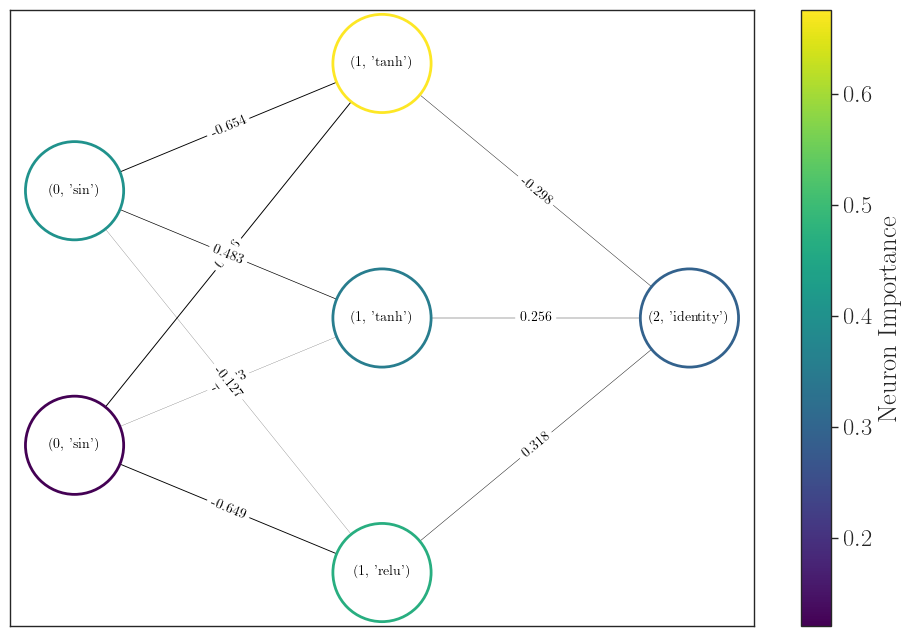

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = mlp(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0])

In [ ]:
mlp = CustomMLP(hetero_config)
opt = optax.sgd(learning_rate=1e-2)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

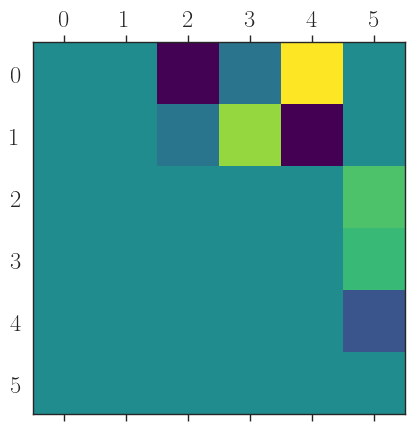

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)

In [ ]:
activation_list = [jax.nn.relu, sin, jax.nn.tanh]
num_epochs = 1000
add_node_every = 10
remove_node_every = 10
key = jax.random.PRNGKey(42)
Loss_history = []
Node_history = []
graph_history = []

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    Loss_history.append(loss)
    Node_history.append(n_neurons)

    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0 and jax.random.uniform(add_key) < 0.05:
        add_key, act_key = jax.random.split(add_key)
        activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
        layers = len(mlp.get_shape()) - 1
        layer = jax.random.randint(act_key, (1,), 0, layers)[0]
        mlp.add_neuron(layer_index=1, activation=activation, key=add_key)
        opt_state = initialize_optimizer_state(mlp, opt)
        print(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
        print(mlp.get_shape())
    
    elif (epoch + 1) % remove_node_every == 0 and jax.random.uniform(sub_key) < 0.05:
        layer_key, neuron_key, sub_key = jax.random.split(sub_key,3)
        layers = len(mlp.get_shape()) - 1
        layer = jax.random.randint(layer_key, (1,), 0, layers)[0]
        layer_neurons = len(mlp.layers[layer])
        if layer_neurons > 0:
            neuron_idx = jax.random.randint(neuron_key, (1,), 0, layer_neurons)[0]
            mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            print(f"Removed neuron from hidden layer {layer+1} at index {neuron_idx}")
            print(mlp.get_shape())

    print(f"Epoch {epoch}, Prediction: {mlp(x)}, Loss: {loss}")

print("Final Prediction:", mlp(x))

Epoch 0, Prediction: [0.24195556], Loss: 0.6022641062736511
Epoch 1, Prediction: [0.25976145], Loss: 0.5746313333511353
Epoch 2, Prediction: [0.27735046], Loss: 0.5479531288146973
Epoch 3, Prediction: [0.29471123], Loss: 0.5222223997116089
Epoch 4, Prediction: [0.3118323], Loss: 0.49743223190307617
Epoch 5, Prediction: [0.3287031], Loss: 0.47357475757598877
Epoch 6, Prediction: [0.34531385], Loss: 0.4506395161151886
Epoch 7, Prediction: [0.3616562], Loss: 0.42861396074295044
Epoch 8, Prediction: [0.37772292], Loss: 0.4074828326702118
Epoch 9, Prediction: [0.39350832], Loss: 0.38722875714302063
Epoch 10, Prediction: [0.41295007], Loss: 0.36783215403556824
Epoch 11, Prediction: [0.44712022], Loss: 0.34462764859199524
Epoch 12, Prediction: [0.47856987], Loss: 0.30567607283592224
Epoch 13, Prediction: [0.50762296], Loss: 0.2718893885612488
Epoch 14, Prediction: [0.5345573], Loss: 0.24243515729904175
Epoch 15, Prediction: [0.5596088], Loss: 0.21663692593574524
Epoch 16, Prediction: [0.58297

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

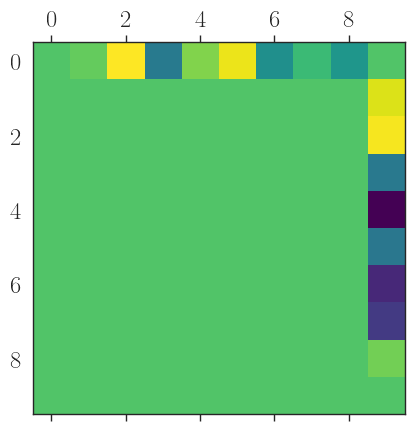

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)

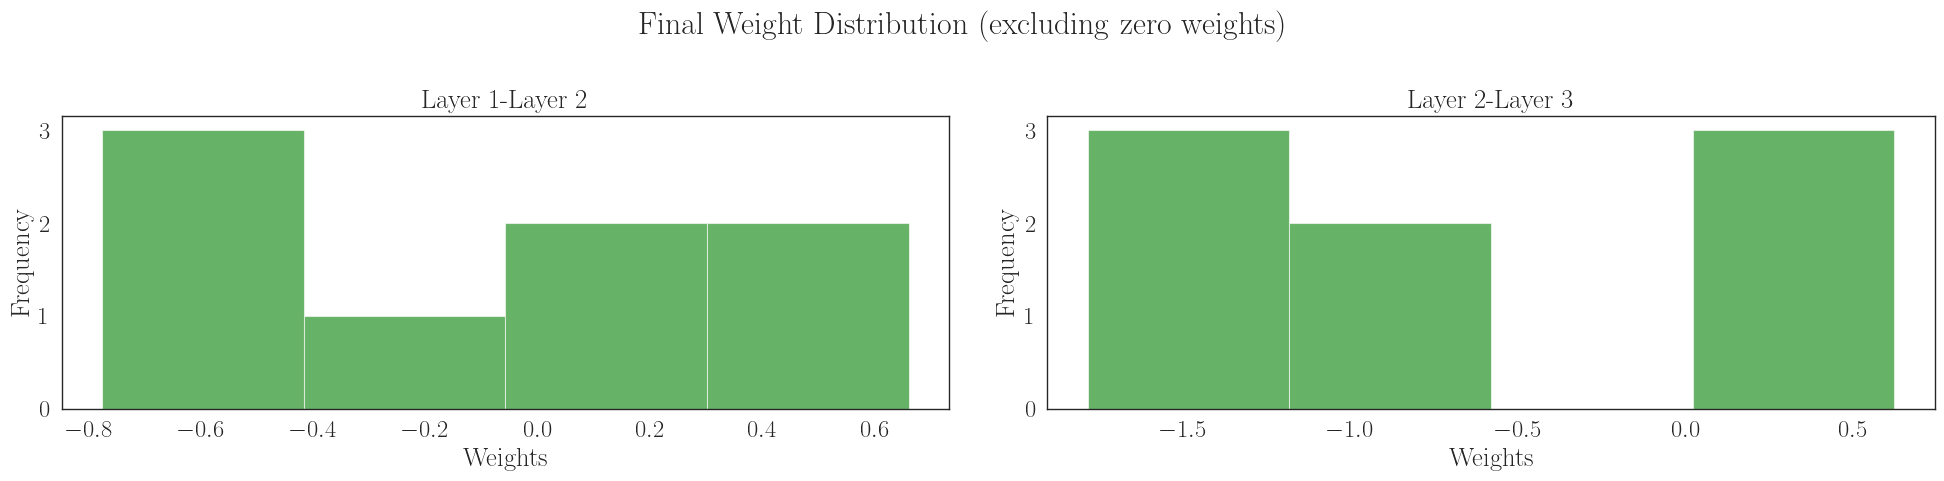

In [ ]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum(mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')

# Display the figure with its subplots
plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.show()

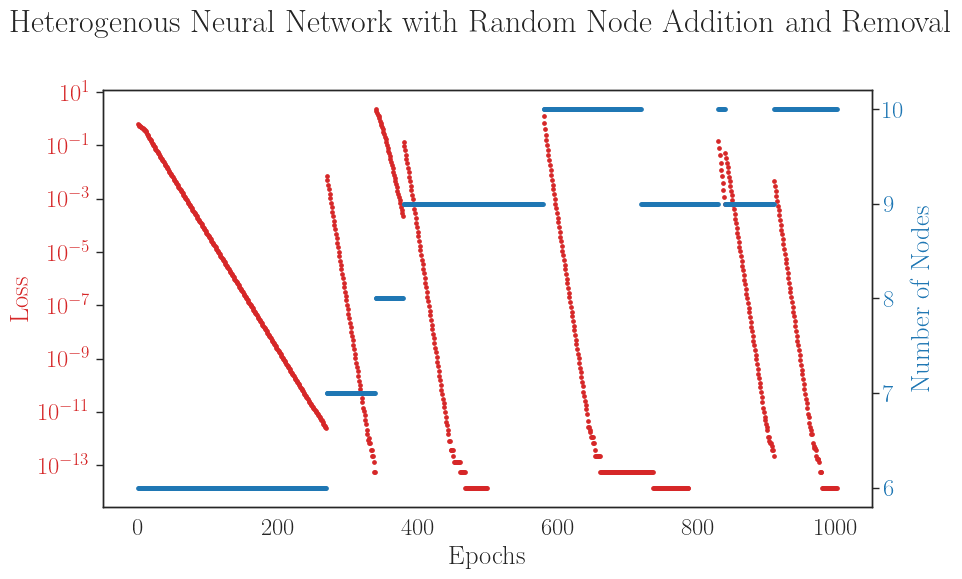

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,num_epochs), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,num_epochs), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Heterogenous Neural Network with Random Node Addition and Removal")
fig.tight_layout()

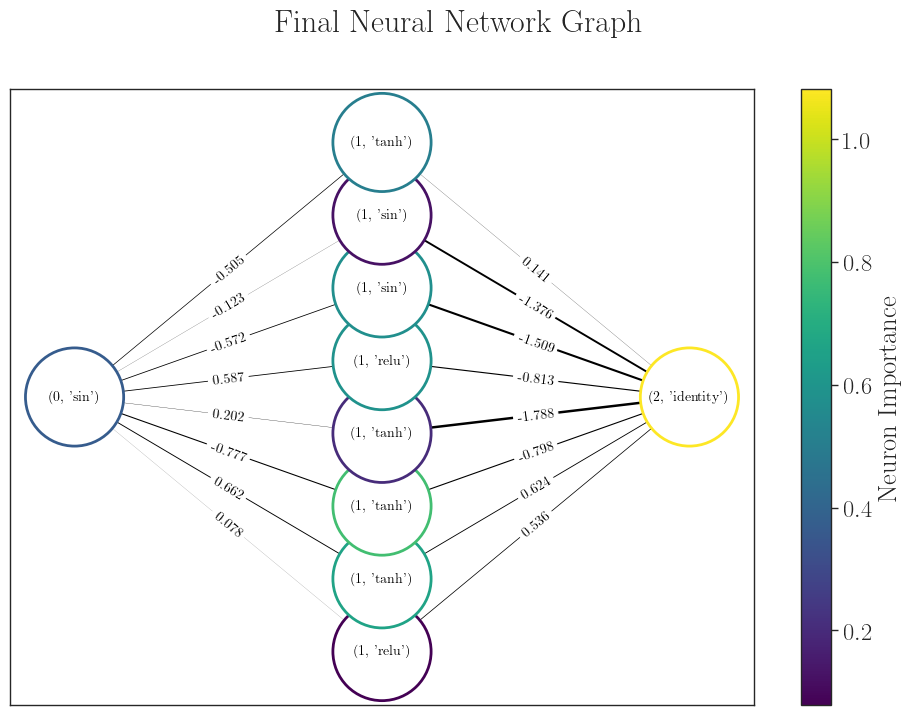

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.suptitle("Final Neural Network Graph")
plt.show()